<a href="https://colab.research.google.com/github/MareMaltese/algoritmos-optimizacion/blob/main/Trabajo_Pr%C3%A1ctico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmos de optimización - Trabajo Práctico<br>
Nombre y Apellidos: María del Mar Maltese<br>
Url: https://github.com/MareMaltese/algoritmos-optimizacion/blob/main/Trabajo_Práctico.ipynb<br>
Google Colab: [colab](https://colab.research.google.com/drive/13H-oaGKmECKWBdPLOdMDTcSqgtii8MXg?usp=sharing) <br>

Problema:
>3. Configuración de Tribunales

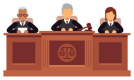
---                                       

# Descripción del problema:
### Problema 3. Generación de Tribunales(I)
* Se precisa configurar tribunales de evaluación para un grupo de 15 alumnos
que desean presentar su Trabajo Fin de Máster (TFM).
* Cada tribunal está compuesto por tres profesores, cada uno desempeñando uno de los
siguientes roles: Presidente, Secretario o Vocal.
* Los profesores han indicado su disponibilidad horaria para participar en los tribunales de 15h a 21h durante la semana del 15 al 19 de abril:
  -  Número de profesores : 10
  - Número de tribunales : 15
  - Disponibilidad/Roles : [https://bit.ly/41QWk8o](https://bit.ly/41QWk8o)
    - 1 indica que profesor tiene disponibilidad
    - 0 en caso contrario

- Hay 15 alumnos, por lo que se deben configurar 15 tribunales buscando la configuración más
equilibrada posible en cuanto a la cantidad de tribunales asignados a cada profesor, es decir,
evitando que un profesor tenga muchos tribunales y otros pocos.
- Obviamente ningún profesor puede asistir a dos tribunales a la misma fecha/hora y no puede ser
convocado a un tribunal al que no tiene disponibilidad.

#Modelo

## - ¿Como represento el espacio de soluciones?
Cada tribunal necesita tres profesores con roles de Presidente, Secretario y Vocal. El espacio de soluciones es la tabla de ejemplo descrita debajo con todas las soluciones válidas, cumpliendo:

1. Cada tribunal tiene 3 profesores distintos (cada uno en un rol, cada profesor puede asumir ciertos roles).

2. Los profesores no son ubicuos, no pueden estar en varios tribunales a la misma hora y día.

3. Los profesores pueden estar o no disponibles según el día y la hora.

4. Distribución es equilibrada entre la carga de trabajo de profesores para que ninguno tenga demasiados asignados en comparación con los demás.

5. El problema pide 15 tribunales para 15 alumnos.

#### Matriz $ solucion $ donde:
- Filas: Representan cada uno de los tribunales $ t $.
- Columnas: Representan el día, hora y cada uno de los 3 profesores.

#### Ejemplo de tabla de salida:

| Tribunal | Fecha | Hora | Presidente | Secretario | Vocal |
|---|---|---|---|---|---|
|1|15/04|16:00|RRD|JLG|MTR|
|2|15/04|18:00|FRJ|BCD|LMP|
|...|...|...|...|...|...|

#### Al implementar dos algoritmos:  
- En el **Voraz**, cada tribunal siempre devuelve el mismo resultado en cada ejecución.
- En el **GRASP**, la selección dentro de la Lista Restringida de Candidatos (RCL) introduce variabilidad, generando diferentes soluciones en distintas ejecuciones.

## 2. ¿Cual es la función objetivo?

El objetivo es minimizar la desigualdad en la carga de trabajo de los profesores, garantizando una distribución lo más equitativa posible.

$$\min \sum_{p \in P} \left( T_p - \frac{3*NT}{NP} \right)^2$$

Donde:
- $ P $ es el conjunto de profesores.
- $ T_p $ es la cantidad de tribunales en los que el profesor $ p $ ha sido asignado.
- $ NT $ es el número total de tribunales.
- $ NP $ es el número total de profesores.
- $ \frac{3*NT}{NP} $ es la *carga de trabajo ideal* por profesor.


## 3. ¿Cómo implemento las restricciones?
Restricciones que se deben cumplir:

1. Cada tribunal tiene 3 profesores asi que se filtran aquellos por rol asociado(presidente, secretario y vocal):
  - Voraz
  ```python
  presidente = next((p for p in disponibles if "P" in roles_df.loc[p, "ROL"]), None)
  secretario = next((p for p in disponibles if "S" in roles_df.loc[p, "ROL"] and p != presidente), None)
  vocal = next((p for p in disponibles if "V" in roles_df.loc[p, "ROL"] and p != presidente and p != secretario), None)
  ```
  - GRASP
  ```python
  presidente = next((p for p in random.sample(RCL, len(RCL)) if "P" in roles_df.loc[p, "ROL"]), None)
  secretario = next((p for p in random.sample(RCL, len(RCL)) if "S" in roles_df.loc[p, "ROL"] and p != presidente), None)
  vocal = next((p for p in random.sample(RCL, len(RCL)) if "V" in roles_df.loc[p, "ROL"] and p != presidente and p != secretario), None)
  ````

  Si no hay suficientes profesores se dejan a None:
  ```python
  if presidente and secretario and vocal:
      solucion_df.loc[t] = [fecha, hora, presidente, secretario, vocal]
      ...
  else:
      solucion_df.loc[t] = [fecha, hora, None, None, None]
  ```

2. Profesores disponibles en hora y fecha:
```python
disponibles = disponibilidad_df[disponibilidad_df[horario] == 1].index.tolist()
```

3. Un profesor solo puede ser seleccionado una vez por tribunal:
```python
p != presidente and p != secretario
```

4. Un profesor solo puede desempeñar los roles en los que está habilitado
```python
if "P" in roles_df.loc[p, "ROL"]
if "S" in roles_df.loc[p, "ROL"]
if "V" in roles_df.loc[p, "ROL"]
```

5. Se balancea la carga ordenando a los profesores menos convocados hasta el momento, y con GRASP se añade aleatoriedad:
  - Voraz:
  ```python
  disponibles = sorted(disponibles, key=lambda p: asignaciones_contador[p])
  ```
  Y se actualizan los contadores
  ```python
  asignaciones_contador[presidente] += 1
  asignaciones_contador[secretario] += 1
  asignaciones_contador[vocal] += 1
  ```
  - GRASP:
  ```python
  disponibles_ordenados = sorted(disponibles, key=lambda p: asignaciones_contador[p])
  RCL = disponibles_ordenados[:RCL_SIZE]
  ```

#Diseño

## 1. ¿Qué técnica se utilizó?
He elegido dos técnicas diferentes para evaluar cual es la mejor
### Voraz
Elegí inicialmente una heurística de tipo voraz porque es un método eficiente que permite encontrar una solución factible en un tiempo razonable, de manera rapida y sencilla de implementar.
- Por la naturaleza del problema en si,
  - Las decisiones se toman tribunal por tribunal, y una vez que se asignan los profesores, no hay necesidad de reconsiderar decisiones previas.
  - Los tribunales son independientes entre sí en horario y profesores, lo que permite una asignación secuencial sin necesidad de mirar atrás.
  - El problema no requiere encontrar una solución óptima global, sino una asignación válida y funcional.

El problema tiene dos restricciones clave:
 1. Disponibilidad horaria: Un profesor solo puede ser asignado si está disponible en ese horario.
 2. Roles permitidos: Un profesor solo puede desempeñar el rol si está habilitado en roles_df.

Con un enfoque voraz, basta con iterar sobre los tribunales y asignar la mejor opción disponible en cada paso. No es necesario explorar todas las combinaciones posibles.

### GRASP (Greedy Randomized Adaptive Search Procedure)
Al encontrar siempre la misma solución que no tenía porque ser la optima decidí probar con un GRASP (Greedy Randomized Adaptive Search Procedure) añade al voraz algo de aleatoriedad para intentar mejorar la calidad de las soluciones.



## 2. ¿Por qué?
1. Eficiencia computacional
2. Minimizan la sobrecarga de algunos profesores  
3. Se adaptan al problema en si garantizando la factibilidad en cada pas ya que se aseguran todas las restricciones
4. Simplicidad y rapidez o un poco más de complejidad y coste computacional a cambio de expandir la busqueda

Ambas técnicas tienen una misma base voraz así que la evolución parecía obvia.

No obstante, estuve comparando otros Métodos de Optimización para la Asignación de Tribunales aprendidos en clase

| **Método** | **Aplicabilidad al problema** | **Pros** | **Contras** |
|------------|-------------------------------|----------|-------------|
| **Heurística Voraz (Greedy)** | ✅ Se usa actualmente | Rápido, simple, encuentra soluciones factibles | No garantiza la mejor solución |
| **Búsqueda Tabú (TA)** | ⚠️ Potencialmente útil | Evita quedarse en óptimos locales | Más costoso, requiere definir memoria tabú |
| **Recocido Simulado (SA)** | ⚠️ Posible mejora | Puede escapar de mínimos locales | Ajuste de parámetros crítico |
| **Optimización por Enjambre de Partículas (PSO)** | 🚫 No aplicable | Bueno para problemas continuos | El problema es discreto, no tiene sentido en este caso |
| **GRASP (Greedy Randomized Adaptive Search Procedure)** | ✅ Podría ser útil | Combinación de heurística y búsqueda local | Más costoso que greedy puro |
| **Algoritmos Evolutivos (EA) / Algoritmos Genéticos (GA)** | ⚠️ Viable pero costoso | Encuentra mejores soluciones con iteraciones | Mucho tiempo de cómputo, requiere codificación y operadores genéticos |
| **Optimización por Colonia de Hormigas (ACO)** | 🚫 No aplicable | Bueno para problemas de rutas y grafos | No tiene una estructura de solución basada en grafos |



#Análisis

## 1. ¿Que complejidad tiene el problema?
El problema de asignación de tribunales es un **problema combinatorio NP-hard**, ya que la cantidad de combinaciones posibles **crece exponencialmente** con el número de tribunales y profesores disponibles.
El espacio de soluciones es enorme, por lo que un enfoque de fuerza bruta es inviable.

### 2. Orden de complejidad y Contabilizar el espacio de soluciones
Dado:
- 15 tribunales
- 10 profesores*
- Cada tribunal tiene 3 profesores (Presidente, Secretario y Vocal)
- Cada profesor tiene restricciones de disponibilidad y roles

El espacio de búsqueda sin restricciones sería:

$$
S = (C_{10,3})^{15}
$$

Donde:

$$
C_{10,3} = \frac{10!}{3!(10-3)!} = 120
$$

Entonces:

$$
S = 120^{15} \approx 1.15 \times 10^{31}
$$


#### Orden de Complejidad:
| **Método**         | **Complejidad**         | **Factible?** |
|-------------------|-----------------------|--------------|
| **Fuerza Bruta**  | $$ O(120^{15}) $$  | 🚫 Imposible |
| **Voraz** | $$ O(m \cdot (n \log n)) $$ | ✅ Rápido |
| **GRASP** | $$ O(k \cdot m \cdot (n \log n)) $$ | ✅ Genera soluciones diversas aunque más costoso |




#Comparación entre Voraz y GRASP

| **Criterio**              | **Greedy (Voraz)** | **GRASP** |
|---------------------------|-------------------|-----------|
| **Tiempo de ejecución**   | ✅ Muy rápido (**O(n)**) | ❗ Más lento (**O(n log n)** debido al ordenamiento y aleatorización) |
| **Distribución de carga** | ❗ Puede generar sobrecarga en algunos profesores | ✅ Balancea mejor la carga |
| **Diversidad de soluciones** | ❗ Siempre genera la misma asignación | ✅ Introduce variabilidad en cada ejecución |
| **Optimización global**   | ❗ No garantiza una mejor solución general | ✅ Puede mejorar distribuciones desfavorables |
| **Facilidad de implementación** | ✅ Simple y directo | ❗ Más complejo por RCL y búsqueda local |


---
#Implementaciones:
# Código algoritmo búsqueda heurística voraz:
Ya que elige localmente la mejor opción sin garantizar la solución óptima global, devolviendo siempre el mismo resultado.

### Librerias necesarias y descarga del xls

In [2]:
import pandas as pd
import os
import random

In [4]:
!pip install gdown
import gdown                       # To download dataset from drive

file_id = '1GLbm7srzHt_SfP1semAfKGUOX5I5oMJd'  # Drive file ID
url = f'https://drive.google.com/uc?id={file_id}'
xls = 'tribunales.csv'
gdown.download(url, xls)

Downloading...
From: https://drive.google.com/uc?id=1GLbm7srzHt_SfP1semAfKGUOX5I5oMJd
To: /content/tribunales.csv
100%|██████████| 18.8k/18.8k [00:00<00:00, 32.2MB/s]


'tribunales.csv'

#### Carga y limpieza de la matriz de disponibilidad

In [5]:
# Cargar las hojas del archivo Excel
disponibilidad_df = pd.read_excel(xls, sheet_name="disponibilidad")

# Eliminar la columna con '#'
disponibilidad_df.drop(columns=['#'], inplace=True)

# Definir parámetros del problema
num_profesores = 10
num_tribunales = 15
num_tribunales_por_dia = 7
inicio_dias = 15

# Generar lista de ids de columna
ultima_hora = 15
new_column_names = ['Profesor']
for i in range(len(disponibilidad_df.iloc[0])):
    if pd.notna(disponibilidad_df.iloc[0, i]):
        if not isinstance(disponibilidad_df.iloc[0, i], str):
          if (ultima_hora > disponibilidad_df.iloc[0, i]):
            inicio_dias += 1
          ultima_hora = disponibilidad_df.iloc[0, i];
          new_column_names = new_column_names + [f"{inicio_dias}_{disponibilidad_df.iloc[0, i]}"]

# Poner la nueva lista de nombres de columna
disponibilidad_df.columns = new_column_names
# Eliminar la primera fila
disponibilidad_df = disponibilidad_df.iloc[1:].reset_index(drop=True)

# Poner la columna primera como ids de profesor
disponibilidad_df.set_index("Profesor", inplace=True)
display(disponibilidad_df)


,15_15,15_16,15_17,15_18,15_19,15_20,15_21,16_15,16_16,16_17,...,18_19,18_20,18_21,19_15,19_16,19_17,19_18,19_19,19_20,19_21
Profesor,,,,,,,,,,,,,,,,,,,,,
RRD,0,1,1,1,0,1,1,1,0,1,...,1,1,1,1,1,1,1,1,0,0
QYV,1,1,1,1,0,0,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1
LHL,0,0,1,1,0,1,1,1,1,1,...,1,0,1,0,1,1,0,1,0,1
HLC,1,0,1,0,1,1,0,1,0,0,...,0,1,1,1,1,1,1,1,1,0
MSB,1,1,0,1,0,1,1,1,1,1,...,0,1,1,1,0,1,1,1,1,0
PMQ,1,1,1,1,1,0,0,1,1,1,...,0,1,1,1,1,1,0,1,0,1
QWF,0,1,1,1,1,1,1,1,1,0,...,0,1,1,1,1,1,1,1,0,1
EBB,1,1,1,1,1,0,0,1,1,0,...,1,1,1,0,1,1,1,0,1,0
IOE,1,0,1,1,0,1,0,0,1,1,...,1,1,0,1,0,1,1,1,1,1


#### Carga de matriz de roles y soluciones

In [6]:
roles_df = pd.read_excel(xls, sheet_name="roles")
roles_df.set_index("Profesor", inplace=True)
display(roles_df)

solucion_df = pd.read_excel(xls, sheet_name="solucion")
solucion_df.set_index("Tribunal", inplace=True)
display(solucion_df)

,ROL
Profesor,
RRD,"P,S,V"
QYV,"P,S,V"
LHL,"P,V"
HLC,"S,V"
MSB,"P,S,V"
PMQ,"P,S,V"
QWF,"S,V"
EBB,"S,V"
IOE,"P,S,V"


,Fecha,Hora,Presidente,Secretario,Vocal
Tribunal,,,,,
1,15.0,16.0,RRD,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [16]:
# Diccionario para contar cuántas veces ha sido asignado un profesor
asignaciones_contador = {prof: 0 for prof in disponibilidad_df.index}
# Crear nueva solucion
solucion_df = pd.DataFrame(index=range(1, num_tribunales+1), columns=["Fecha", "Hora", "Presidente", "Secretario", "Vocal"])

# Asignación de profesores a los tribunales
for t in solucion_df.index:
    # Obtener el horario
    horario = disponibilidad_df.columns[t - 1]
    fecha, hora = horario.split("_")
    # Filtrar profesores en ese horario
    disponibles = disponibilidad_df[disponibilidad_df[horario] == 1].index.tolist()
    # Ordenar profesores menos asignados
    disponibles = sorted(disponibles, key=lambda p: asignaciones_contador[p])
    # Seleccionar profesores según los roles disponibles y con menos carga
    presidente = next((p for p in disponibles if "P" in roles_df.loc[p, "ROL"]), None)
    secretario = next((p for p in disponibles if "S" in roles_df.loc[p, "ROL"] and p != presidente), None)
    vocal = next((p for p in disponibles if "V" in roles_df.loc[p, "ROL"] and p != presidente and p != secretario), None)
    # Asignar al tribunal si hay suficientes profesores
    if presidente and secretario and vocal:
        solucion_df.loc[t] = [fecha, hora, presidente, secretario, vocal]
        # Actualizar el contador de asignaciones
        asignaciones_contador[presidente] += 1
        asignaciones_contador[secretario] += 1
        asignaciones_contador[vocal] += 1
    else:
        solucion_df.loc[t] = [fecha, hora, None, None, None]  # Tribunal sin asignar si no hay suficientes

display(solucion_df)

,Fecha,Hora,Presidente,Secretario,Vocal
1,15,15,QYV,HLC,MSB
2,15,16,RRD,PMQ,QWF
3,15,17,LHL,EBB,IOE
4,15,18,IOA,RRD,QYV
5,15,19,PMQ,HLC,QWF
6,15,20,LHL,MSB,IOE
7,15,21,IOA,RRD,LHL
8,16,15,MSB,EBB,HLC
9,16,16,QYV,PMQ,QWF
10,16,17,IOE,RRD,QYV


## GRASP

In [15]:
# Diccionario para contar cuántas veces ha sido asignado un profesor
asignaciones_contador = {prof: 0 for prof in disponibilidad_df.index}
# Crear nueva solucion
solucion_df = pd.DataFrame(index=range(1, num_tribunales+1), columns=["Fecha", "Hora", "Presidente", "Secretario", "Vocal"])

# Definir tamaño de la Lista Restringida de Candidatos (RCL)
RCL_SIZE = 3

# Asignación de profesores a los tribunales
for t in solucion_df.index:
    # Obtener el horario
    horario = disponibilidad_df.columns[t - 1]
    fecha, hora = horario.split("_")
    # Filtrar profesores en ese horario
    disponibles = disponibilidad_df[disponibilidad_df[horario] == 1].index.tolist()
    # Ordenar profesores menos asignados
    disponibles_ordenados = sorted(disponibles, key=lambda p: asignaciones_contador[p])
    # Crear Lista Restringida de Candidatos
    RCL = disponibles_ordenados[:RCL_SIZE]
    # Seleccionar profesores al azar desde la RCL, respetando roles
    presidente = next((p for p in random.sample(RCL, len(RCL)) if "P" in roles_df.loc[p, "ROL"]), None)
    secretario = next((p for p in random.sample(RCL, len(RCL)) if "S" in roles_df.loc[p, "ROL"] and p != presidente), None)
    vocal = next((p for p in random.sample(RCL, len(RCL)) if "V" in roles_df.loc[p, "ROL"] and p != presidente and p != secretario), None)
    # Asignar al tribunal si hay suficientes profesores
    if presidente and secretario and vocal:
        solucion_df.loc[t] = [fecha, hora, presidente, secretario, vocal]
        # Actualizar el contador de asignaciones
        asignaciones_contador[presidente] += 1
        asignaciones_contador[secretario] += 1
        asignaciones_contador[vocal] += 1
    else:
        solucion_df.loc[t] = [fecha, hora, None, None, None]  # Tribunal sin asignar si no hay suficientes

display(solucion_df)

,Fecha,Hora,Presidente,Secretario,Vocal
1,15,15,MSB,HLC,QYV
2,15,16,RRD,QWF,PMQ
3,15,17,LHL,IOE,EBB
4,15,18,QYV,IOA,RRD
5,15,19,PMQ,QWF,HLC
6,15,20,LHL,IOE,MSB
7,15,21,RRD,IOA,LHL
8,16,15,MSB,EBB,HLC
9,16,16,QYV,QWF,PMQ
10,16,17,RRD,IOE,QYV


#Conclusiones
### ¿GRASP mejora este problema?
Desde luego evita la sobrecarga de ciertos profesores

Voraz siempre selecciona a los mismos profesores primero, lo que hace que algunos sean asignados más veces y que a otros. Por eso GRASP es mejor ya que introduce aleatoriedad controlada con la Lista Restringida de Candidatos (RCL), lo que iguala más la asignación e introduce diversidad en la solución

En el voraz, cada ejecución da el mismo resultado mientras que GRASP, al hacer la elección aleatoria dentro de la RCL provoca para cada ejecución una solución diferente, lo que ayuda a explorar diferentes soluciones lo que nos podría llevar a encontrar la solución óptima global.

### En mi opinión, vale la pena usar GRASP en este problema:

Ya que el objetivo es equilibrar mejor la carga y llegar a encontrar la solución global optima. A pesar de que, esta claro que penaliza en tiempo de ejecución, como nuestro problema solo solicita 15 tribunales es asumible.

A continuación muestro en un gráfico, las puntaciones que he considerado según los siguientes criterios de comparación.

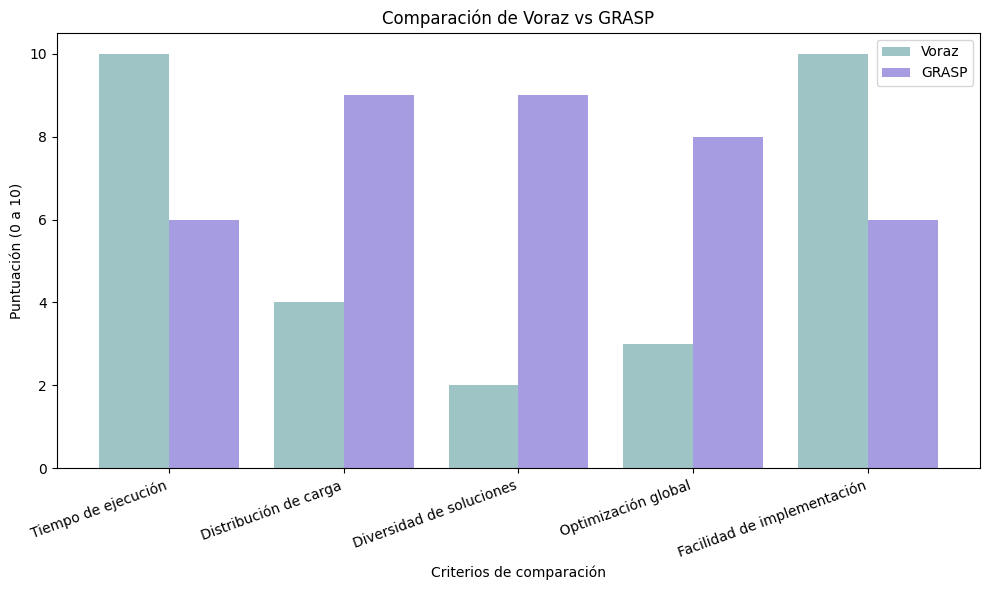

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Definir categorías (Criterios de comparación)
criterios = [
    "Tiempo de ejecución",
    "Distribución de carga",
    "Diversidad de soluciones",
    "Optimización global",
    "Facilidad de implementación"
]
voraz_scores = [10, 4, 2, 3, 10]
grasp_scores = [6, 9, 9, 8, 6]

x = np.arange(len(criterios))
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 0.2, voraz_scores, width=0.4, label="Voraz", color="cadetblue", alpha=0.6)
ax.bar(x + 0.2, grasp_scores, width=0.4, label="GRASP", color="slateblue", alpha=0.6)
ax.set_xlabel("Criterios de comparación")
ax.set_ylabel("Puntuación (0 a 10)")
ax.set_title("Comparación de Voraz vs GRASP")
ax.set_xticks(x)
ax.set_xticklabels(criterios, rotation=20, ha="right")
ax.legend()
plt.tight_layout()
plt.show()